# Humpback Whale Identifaction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from glob import glob

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from functools import partial
from multiprocessing import Pool

from PIL import Image

import numpy as np

%matplotlib inline

Using TensorFlow backend.


## 0. Importing Data and Primitive Analysis

In [2]:
train_df = pd.read_csv('Datas/train.csv')
train_df.head()
train_images = glob("Datas/train/*jpg")

In [3]:
train_df['Id'] = train_df['Id'].astype('category')
train_df['Id'].value_counts().head()

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
Name: Id, dtype: int64

In [4]:
num_categories = len(train_df['Id'].unique())
     
print(f'Number of categories: {num_categories}')

Number of categories: 4251


In [5]:
train_df["Image"] = train_df["Image"].map( lambda x : "Datas/train/"+x)
ImageToLabelDict = dict(zip(train_df["Image"], train_df["Id"]))

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 2 columns):
Image    9850 non-null object
Id       9850 non-null category
dtypes: category(1), object(1)
memory usage: 289.5+ KB


In [7]:
rand_rows = train_df.sample(frac=1.)[ : 20]
photos = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

In [8]:
def plot_images(photos, labels, rows = int(math.sqrt(len(photos)))):
    
    figure = plt.figure(figsize = (13, 8))
    cols = len(photos) // rows + 1

    for i in range(len(photos)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=14)
        plt.imshow(photos[i], cmap='gray')
        
def plot_photos_with_filename_training(filenames, labels, rows=int(math.sqrt(len(photos)))):
    photos = [plt.imread(f'{filename}') for filename in filenames]
    return plot_images(photos, labels, rows)

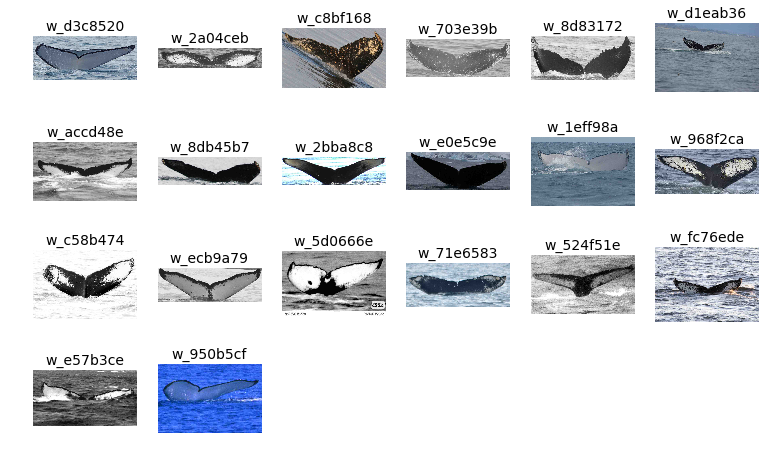

In [9]:
im_training_sample = plot_photos_with_filename_training(photos, labels)
im_training_sample

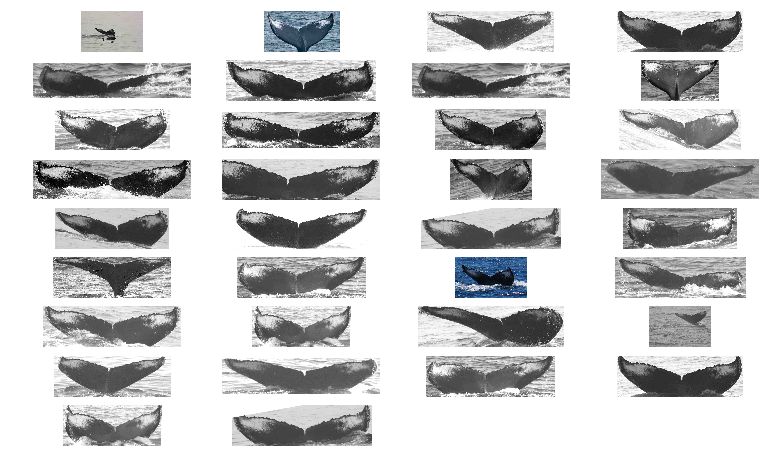

In [10]:
w_1287fbc = train_df[train_df['Id'] == 'w_1287fbc']
plot_photos_with_filename_training(list(w_1287fbc['Image']), None, rows=9)

In [11]:
def get_size(filename, dataset):
    filepath = {
        'train': f'{filename}',
    }[dataset]
    return Image.open(filepath).size

get_size_train = partial(get_size, dataset='train')

In [12]:
with Pool(4) as p:
    sizes = p.map(get_size_train, train_df['Image'])

In [13]:
train_df['width'] = train_df['height'] = None
train_df[['width', 'height']] = sizes
train_df.head()

,Image,Id,width,height
0,Datas/train/00022e1a.jpg,w_e15442c,699,500
1,Datas/train/000466c4.jpg,w_1287fbc,1050,700
2,Datas/train/00087b01.jpg,w_da2efe0,1050,368
3,Datas/train/001296d5.jpg,w_19e5482,397,170
4,Datas/train/0014cfdf.jpg,w_f22f3e3,700,398


In [14]:
train_df.describe()

,width,height
count,9850.000000,9850.000000
mean,968.758985,478.467919
std,157.889631,162.179876
min,64.000000,30.000000
25%,989.000000,347.000000
50%,1050.000000,476.000000
75%,1050.000000,600.000000
max,1050.000000,1613.000000


In [15]:
SIZE = 64
#image are imported with a resizing and a black and white conversion
def ImportImage(filename):
    img = Image.open(filename).convert("LA").resize((SIZE,SIZE))
    return np.array(img)[:,:,0]
train_img = np.array([ImportImage(img) for img in train_images])
x = train_img

In [16]:
print( "%d training images" %x.shape[0])

print( "Nbr of samples/class\tNbr of classes")
for index, val in train_df["Id"].value_counts().value_counts().sort_index().iteritems():
    print( "%d\t\t\t%d" %(index,val))

9850 training images
Nbr of samples/class	Nbr of classes
1			2220
2			1034
3			492
4			192
5			102
6			61
7			40
8			23
9			21
10			9
11			7
12			7
13			9
14			5
15			4
16			5
17			4
18			2
19			2
20			1
21			3
22			3
23			1
26			1
27			1
34			1
810			1


## 1. Advanced Data Tackling

In [17]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform(x)

y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)

In [18]:
def plotImages(images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape((SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

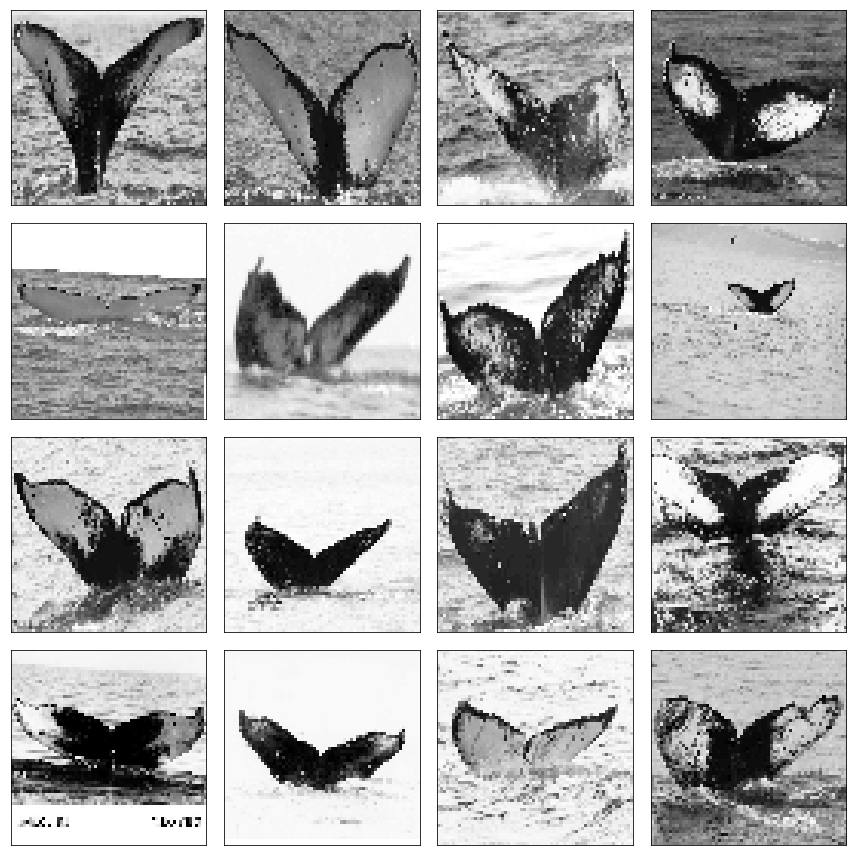

In [19]:
plotImages(x)

## 2. Image augmentation with Keras prebuilt

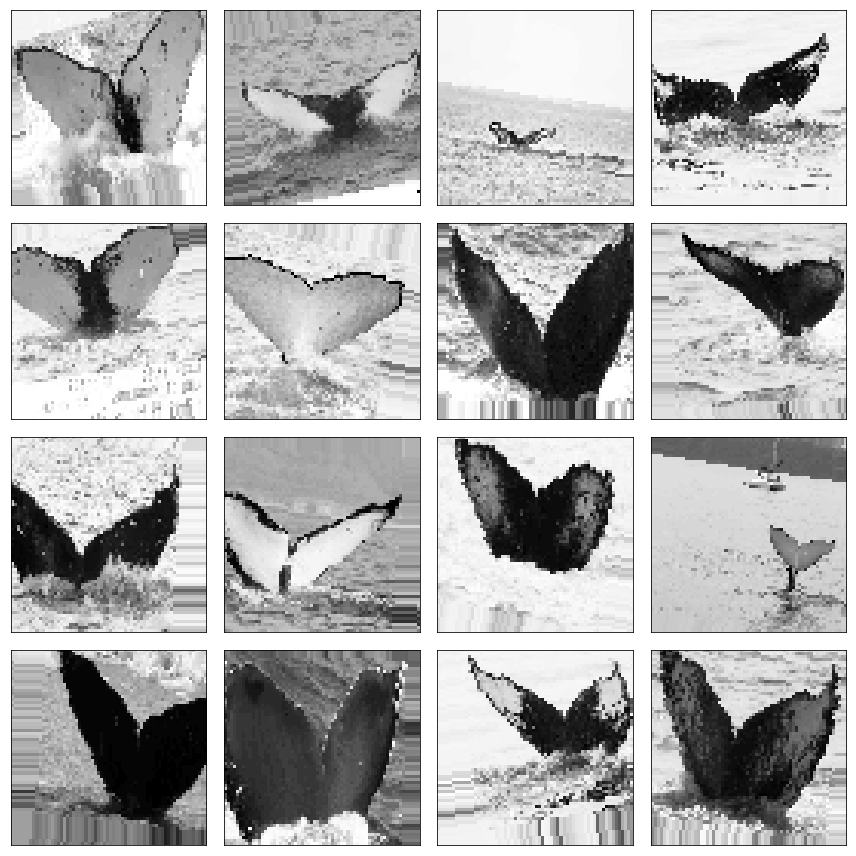

In [20]:
#use of an image generator for preprocessing and data augmentation
x = x.reshape((-1,SIZE,SIZE,1))
input_shape = x[0].shape
x_train = x.astype("float32")
y_train = y_cat

image_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#training the image preprocessing
image_gen.fit(x_train, augment=True)

#visualization of some images out of the preprocessing
augmented_images, _ = next( image_gen.flow( x_train, y_train.toarray(), batch_size=4*4))
plotImages( augmented_images)

## 3. Building and Training Model

In [21]:
batch_size = 128
num_classes = len(y_cat.toarray()[0])
epochs = 40

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

x_train shape: (9850, 64, 64, 1)
9850 train samples


In [ ]:
model = Sequential()
model.add(Conv2D(48, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch=25,
          epochs=epochs,
          verbose=1)

#score = model.evaluate(x_train, y_train, verbose=0)
#print('Training loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))